# ESM Multi-Target Fine-Tuning and Embedding Comparison

This notebook walks through the process of using a pre-trained ESM model for a **multi-class classification** task. It generates protein embeddings, fine-tunes the model on multiple targets (including a 'Non-Binder' category), and compares the embedding space before and after fine-tuning using PCA and t-SNE.

## 1. Setup and Imports

First, let's install and import all the necessary libraries. Ensure you have a GPU available for faster training.

In [23]:
%pip install -q transformers datasets scikit-learn pandas torch seaborn matplotlib accelerate

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import sys
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from scipy.special import softmax
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import hashlib
import json

## 2. Configuration

Set all your parameters in this cell. This replaces the command-line arguments from the original script.

In [ ]:
class Config:
    # --- Input and Output ---
    # IMPORTANT: Make sure this CSV file is uploaded to your notebook environment!
    CSV_PATH = "../Data/TIMP_binder_gen.csv"
    OUTPUT_DIR = "../Local/esm_gen_out"
    SEQ_COL = "Full Seq" # Column with protein sequences
    LABEL_COL = "Target" # Column with target labels
    BINDING_COL = "Encoding" # Column indicating positive (1) or negative (0) binding
    RESIDUE_COL = "Residues"

    # --- Model and Training ---
    MODEL_ID = "facebook/esm2_t33_650M_UR50D"
    #MODEL_ID = "facebook/esm2_t30_150M_UR50D"
    #MODEL_ID = "facebook/esm2_t6_8M_UR50D" # Smaller model for testing; switch to larger for better results

    # --- Generation Parameters ---
    CANONICAL_TEMPLATE_UNIPROT_ID = "P35625" # Human TIMP-3
    #TARGET_UNIPROT_ID = "P14780" # Human MMP9, default sequence
    NUM_SEQUENCES_TO_GENERATE = 10000 # Number of new sequences to create for each class
    LOOP = "AB"

    # --- Derived Paths (Generated Automatically) ---
    
    # This derives the model path from your training OUTPUT_DIR and MODEL_ID
    @property
    def MODEL_PATH(self):
        model_tag = self.MODEL_ID.split('/')[-1]
        return Path(self.OUTPUT_DIR) / f"finetuned_{model_tag}"

    # This creates a unique filename for the output plot
    @property
    def OUTPUT_PLOT_FILENAME(self):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        return f"predicted_tsne_plot_{timestamp}.png"
    
    # This creates a unique filename for the output CSV
    @property
    def OUTPUT_CSV_FILENAME(self):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        plot_dir = Path(self.OUTPUT_DIR)
        plot_dir.mkdir(parents=True, exist_ok=True)
        return plot_dir / f"prediction_results_{timestamp}.csv"

    # This creates a unique filename for the output LaTeX file
    @property
    def OUTPUT_LATEX_FILENAME(self):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        plot_dir = Path(self.OUTPUT_DIR)
        plot_dir.mkdir(parents=True, exist_ok=True)
        return plot_dir / f"prediction_results_{timestamp}.tex"

config = Config()

## 3. Helper Functions

These are the utility functions from the script for device detection, embedding computation, and plotting.

In [41]:
def get_device():
    """Detects and returns the available hardware device."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available(): # For Apple Silicon
        return torch.device("mps")
    else:
        return torch.device("cpu")

def load_sequences_from_csv(filepath, seq_column, residue_column):
    """
    Loads sequences and residue labels from a CSV file.
    Expects sequences to be in seq_column and labels in residue_column.
    Strips whitespace and ignores empty/NaN rows for sequences.
    """
    try:
        df = pd.read_csv(filepath)
        
        if seq_column not in df.columns:
            print(f"\n[ERROR] Sequence column '{seq_column}' not found in file: {filepath}")
            print(f"Available columns are: {list(df.columns)}")
            print(f"Please update 'SEQ_COL' in the Config class.")
            sys.exit(1)

        # Check for residue column, but don't exit if missing. Just warn.
        if residue_column not in df.columns:
            print(f"\n[Warning] Residue column '{residue_column}' not found in file: {filepath}.")
            print(f"Available columns are: {list(df.columns)}")
            print("Plot will not have residue labels. Using default 'Seq_N' labels.")
            # Create default labels if column is missing
            residue_col_data = [f"Seq_{i}" for i in range(len(df))]
        else:
            # Handle potential NaNs in residue column by filling them
            residue_col_data = df[residue_column].fillna('N/A').astype(str)

        # Create a clean dataframe with just the columns we need
        clean_df = pd.DataFrame({
            'sequence': df[seq_column].astype(str),
            'residue': residue_col_data
        })

        # Filter out rows with invalid sequences
        clean_df = clean_df.dropna(subset=['sequence'])
        clean_df = clean_df[clean_df['sequence'].str.strip() != '']
        
        # Get the final lists
        sequences = clean_df['sequence'].str.strip().tolist()
        residues = clean_df['residue'].tolist()
        
        if not sequences:
            print(f"[Warning] No valid sequences found in column '{seq_column}' in file: {filepath}")
            return [], []
            
        return sequences, residues
        
    except FileNotFoundError:
        print(f"\n[ERROR] Sequences file not found at path: {filepath}")
        print("Please make sure you have:")
        print(f"1. A file named '{filepath}'.")
        print(f"2. That file has a column named '{seq_column}' containing your sequences.")
        print(f"3. Optionally, a column named '{residue_column}' for labels.")
        sys.exit(1)
    except Exception as e:
        print(f"\n[ERROR] Could not read sequences file: {e}")
        sys.exit(1)


def compute_predictions_and_embeddings(model, tokenizer, sequences, residues, device):
    """
    Predicts the class and computes embeddings for a list of sequences.
    """
    model.to(device)
    model.eval()
    
    results = []
    all_embeddings = []
    all_predicted_labels = []

    with torch.no_grad():
        # Iterate over sequences AND residues together
        for seq, residue in tqdm(zip(sequences, residues), desc="Computing Predictions & Embeddings", total=len(sequences)):
            # Tokenize the sequence
            inputs = tokenizer(seq, return_tensors="pt", truncation=True, max_length=1022, padding=True).to(device)
            
            # Get model outputs (logits) and hidden states
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits
            
            # Compute embedding (average pool of last hidden state)
            embedding = outputs.hidden_states[-1].mean(dim=1).squeeze().cpu().numpy()
            all_embeddings.append(embedding)
            
            # Convert logits to probabilities
            probabilities = softmax(logits.cpu().numpy().flatten())
            
            # Get the predicted class ID and its confidence
            predicted_class_id = np.argmax(probabilities)
            confidence = probabilities[predicted_class_id]
            
            # Map class ID to label name (e.g., "MMP3", "Non-Binder")
            predicted_label = model.config.id2label[predicted_class_id]
            all_predicted_labels.append(predicted_label)
            
            # Store detailed results for the table
            result_details = {
                "Sequence": seq[:30] + "..." if len(seq) > 30 else seq,
                "Residue": residue,
                "Predicted_Class": predicted_label,
                "Confidence": f"{confidence:.4f}"
            }
            
            # Add probabilities for all classes
            for i, prob in enumerate(probabilities):
                label_name = model.config.id2label[i]
                result_details[f"Prob_{label_name}"] = f"{prob:.4f}"
                
            results.append(result_details)
            
    return pd.DataFrame(results), np.vstack(all_embeddings), all_predicted_labels

def plot_tsne_predictions(new_embeddings, new_labels, residue_labels, filename):
    """
    Runs t-SNE on the new predictions and saves a plot colored by the predicted class
    and labeled by the residue.
    """
    print(f"\n--- Generating t-SNE plot for predictions ---")
    
    # Run t-SNE
    print("Running t-SNE... (this may take a moment)")
    # Note: perplexity must be less than n_samples
    perplexity = min(30, len(new_embeddings) - 1)
    if perplexity <= 0:
        print("[Warning] Not enough samples to run t-SNE. Skipping plot.")
        return

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, max_iter=300)
    tsne_results = tsne.fit_transform(new_embeddings)
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'tsne-1': tsne_results[:, 0],
        'tsne-2': tsne_results[:, 1],
        'Predicted_Label': new_labels,
        'Residue': residue_labels
    })
    
    # Get all unique labels for consistent coloring
    hue_order = sorted(list(set(new_labels)))
    
    # Plot
    plt.figure(figsize=(14, 10)) # Made figure wider to accommodate labels
    ax = sns.scatterplot(
        data=plot_df,
        x='tsne-1',
        y='tsne-2',
        hue='Predicted_Label',
        hue_order=hue_order,
        s=100,
        alpha=0.7
    )
    
    # Add text labels for each point
    # Use adjust_text if available for better label placement
    try:
        from adjustText import adjust_text
        texts = []
        for i in range(plot_df.shape[0]):
            texts.append(ax.text(
                plot_df['tsne-1'][i],
                plot_df['tsne-2'][i],
                plot_df['Residue'][i],
                horizontalalignment='left',
                size='small',
                color='black'
            ))
        print("Adjusting text labels for plot...")
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    except ImportError:
        print("[Info] 'adjustText' library not found. Labels may overlap.")
        print("Install with: pip install adjustText")
        for i in range(plot_df.shape[0]):
            ax.text(
                plot_df['tsne-1'][i] + 0.1, # Offset label slightly
                plot_df['tsne-2'][i] + 0.1, # Offset label slightly
                plot_df['Residue'][i],
                horizontalalignment='left',
                size='small',
                color='black',
                weight='semibold'
            )
    
    plt.title('t-SNE Plot of Predicted Sequences (Labeled by Residue)', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Predicted Class', bbox_to_anchor=(1.05, 1), loc=2)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for legend
    plt.savefig(filename)
    plt.show()
    print(f"t-SNE plot saved to: {filename}")
    plt.close()

def save_df_to_latex_doc(df, filename):
    """Saves a DataFrame as a complete, runnable LaTeX document."""
    print(f"\n--- Saving LaTeX table to: {filename} ---")
    
    # Generate the table string. Use booktabs for quality, longtable for pages.
    # escape=True handles special LaTeX characters like _
    try:
        # Create a copy to avoid SettingWithCopyWarning if we needed to modify
        df_copy = df.copy()
        
        # Shorten the 'Sequence' column for LaTeX output to prevent overflow
        if 'Sequence' in df_copy.columns:
             df_copy['Sequence'] = df_copy['Sequence'].str.slice(0, 20) + '...'
        
        latex_table = df_copy.to_latex(
            index=False,
            longtable=True,
            escape=True,
            caption="ESM Binder Prediction Results.",
            label="tab:results",
            header=True
        )
        
        # Clean up column headers (replace _ with \_)
        # This is sometimes missed by the escape function for headers
        latex_table = latex_table.replace('_', r'\_')

    except ImportError:
        print("[Warning] `lxml` not found. LaTeX output may be basic.")
        print("Install with: pip install lxml")
        latex_table = df.to_latex(index=False, escape=True)
    except Exception as e:
        print(f"[Error] Failed to generate LaTeX table string: {e}")
        return

    # Create the full .tex document string
    tex_doc = f"""
\\documentclass[10pt, a4paper, landscape]{{article}}
\\usepackage[utf8]{{inputenc}}
\\usepackage[a4paper, margin=2cm, landscape]{{geometry}}
\\usepackage{{booktabs}}  % For \\toprule, \\midrule, \\bottomrule
\\usepackage{{longtable}} % For tables that span multiple pages
\\usepackage{{array}}     % For better column formatting
\\usepackage{{graphicx}}  % In case table has images

\\title{{ESM Binder Prediction Results}}
\\author{{Generated by predict_binders.py}}
\\date{{\\today}}

\\begin{{document}}

\\maketitle

\\section*{{Prediction Results}}
\\begingroup
\\centering
\\scriptsize % Use a smaller font for potentially wide tables
{latex_table}
\\endgroup

\\end{{document}}
"""
    # Write the file
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(tex_doc)
        print(f"Successfully saved LaTeX document to {filename}")
    except Exception as e:
        print(f"[ERROR] Could not save LaTeX file: {e}")



### Run Model

Using device: cuda
Using base model: facebook/esm2_t33_650M_UR50D
--- Loading Fine-Tuned Model from: esm_gen_out\finetuned_esm2_t33_650M_UR50D ---

--- Loading data from: TIMP_binder_gen.csv (Seq Col: 'Full Seq', Residue Col: 'Residues') ---

--- Predicting 21 Unknown Sequences ---


Computing Predictions & Embeddings:   0%|          | 0/21 [00:00<?, ?it/s]


--- Prediction Results ---
                         Sequence Residue Predicted_Class Confidence Prob_MMP9 Prob_Non-Binder
CTCSPSHPQDAFCNSDIVIRAKVVGKKLVK...  AGESNA      Non-Binder     0.9933    0.0067          0.9933
CTCSPSHPQDAFCNSDIVIRAKVVGKKLVK...  AGESNC      Non-Binder     0.9657    0.0343          0.9657
CTCSPSHPQDAFCNSDIVIRAKVVGKKLVK...  AGESTA      Non-Binder     0.9277    0.0723          0.9277
CTCSPSHPQDAFCNSDIVIRAKVVGKKLVK...  AGESTC      Non-Binder     0.9987    0.0013          0.9987
CTCSPSHPQDAFCNSDIVIRAKVVGKKLVK...  ASESNA            MMP9     0.9995    0.9995          0.0005
CTCSPSHPQDAFCNSDIVIRAKVVGKKLVK...  ASESNC            MMP9     0.9974    0.9974          0.0026
CTCSPSHPQDAFCNSDIVIRAKVVGKKLVK...  ASESTA            MMP9     0.9998    0.9998          0.0002
CTCSPSHPQDAFCNSDIVIRAKVVGKKLVK...  ASESTC            MMP9     0.9998    0.9998          0.0002
CTCSPSHPQDAFCNSDIVIRAKVVGKKLVK...      WT            MMP9     0.9975    0.9975          0.0025
CTCSPSHPQDAFCNSDIVIRAK

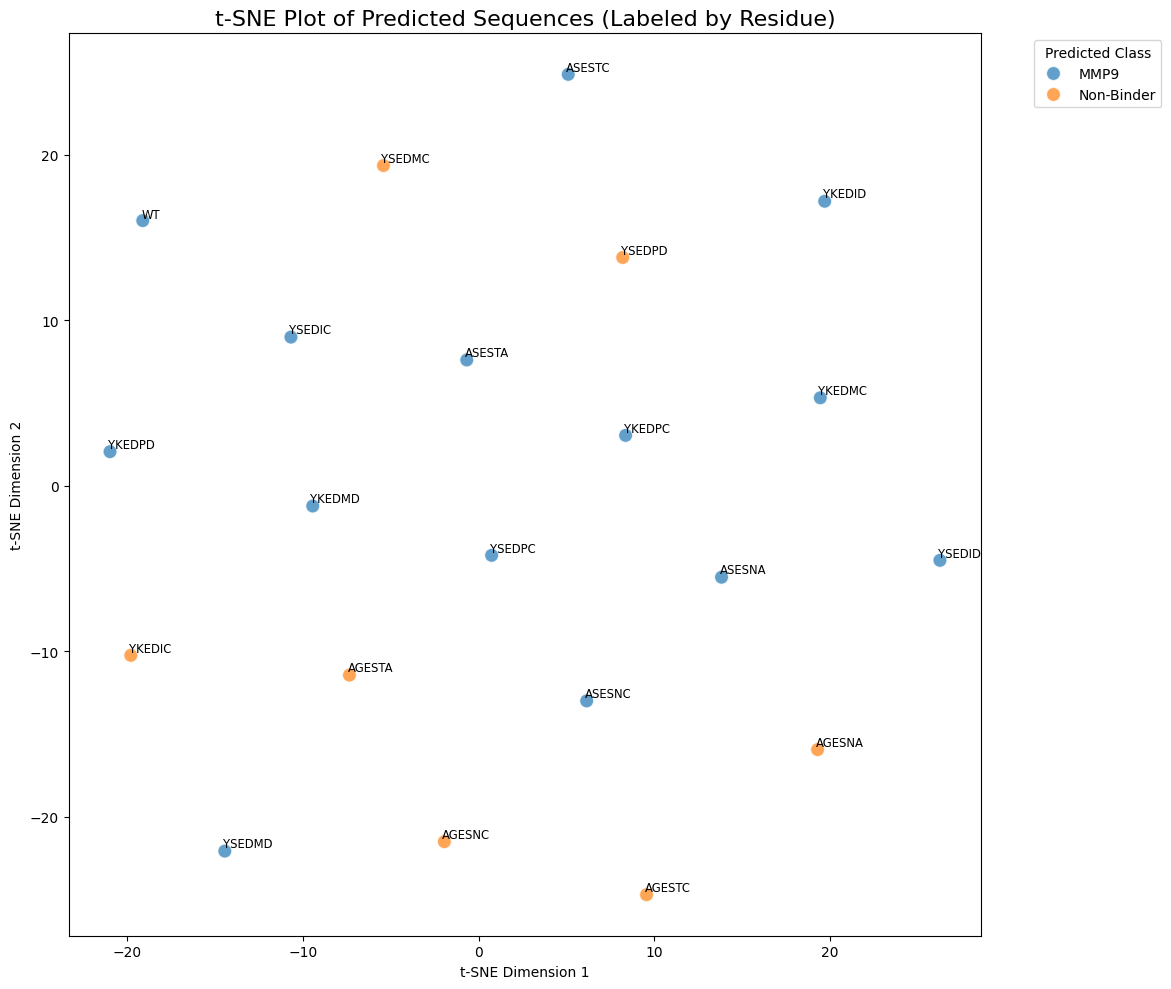

t-SNE plot saved to: predicted_tsne_plot_20251023_155731.png


In [42]:
config = Config()
device = get_device()

print(f"Using device: {device}")
print(f"Using base model: {config.MODEL_ID}")

# Check if the model path looks valid before trying to load
model_path = config.MODEL_PATH
if not model_path.exists() or not (model_path / 'config.json').exists():
    print(f"\n[ERROR] Could not find a valid model at path: {model_path}")
    print("Please make sure you have:")
    print("1. Run the 'Run_tSNE.ipynb' notebook to train and save the model.")
    print("2. Checked that 'OUTPUT_DIR' and 'MODEL_ID' in the Config class are correct.")
    sys.exit(1)
    
print(f"--- Loading Fine-Tuned Model from: {model_path} ---")

# Load the fine-tuned model and tokenizer from the path
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

model.to(device) # Move model to device

# Load sequences AND residues from the file specified in Config
print(f"\n--- Loading data from: {config.CSV_PATH} (Seq Col: '{config.SEQ_COL}', Residue Col: '{config.RESIDUE_COL}') ---")
unknown_sequences, unknown_residues = load_sequences_from_csv(
    config.CSV_PATH, 
    config.SEQ_COL,
    config.RESIDUE_COL
)

if not unknown_sequences:
    print(f"\n[WARNING] No sequences found in '{config.CSV_PATH}'. Please check the file and 'SEQ_COL' in the Config.")
    print("Skipping prediction and plotting.")
else:
    print(f"\n--- Predicting {len(unknown_sequences)} Unknown Sequences ---")
    
    # Get predictions and embeddings for NEW sequences
    predictions_df, new_embeddings, new_labels = compute_predictions_and_embeddings(
        model, tokenizer, unknown_sequences, unknown_residues, device
    )
    
    # --- Display Results Table ---
    print("\n--- Prediction Results ---")
    # Set pandas display options for wider columns
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_colwidth', None)
    print(predictions_df.to_string(index=False)) # Use print() for terminal output

    # --- Save Results to Files ---
    csv_filename = config.OUTPUT_CSV_FILENAME
    latex_filename = config.OUTPUT_LATEX_FILENAME
    
    print(f"\n--- Saving results to CSV: {csv_filename} ---")
    predictions_df.to_csv(csv_filename, index=False)
    print(f"Successfully saved CSV.")
    
    save_df_to_latex_doc(predictions_df, latex_filename)
    
    # --- Generate t-SNE plot ---
    
    # Plot and save
    plot_filename = config.OUTPUT_PLOT_FILENAME
    plot_tsne_predictions(
        new_embeddings,
        new_labels,
        unknown_residues, # Pass the residue labels for plotting
        plot_filename
    )